# Link prediction results
In this notebook, we'll look at the results of our STHN model.

In [16]:
from collections import defaultdict
import matplotlib.pyplot as plt
import torch
import sys
sys.path.append('../../STHN/')
from model import Multiclass_Interface as STHN_Interface
from construct_subgraph import get_parallel_sampler, get_mini_batch
from link_pred_train_utils import compute_sign_feats
from data_process_utils import get_random_inds
from utils import load_feat
import pandas as pd
import numpy as np
from tqdm import tqdm

## Read in & plot the per-epoch performance values
Unfortunately, the code doesn't have an option to save the epoch performance values as anything, the only option is to direct the `stdout` to a file, so we'll need to define our own little parser.

In [2]:
with open('../job_scripts/sthn_dt_24h.o') as f:
    performance_vals = [line.strip() for line in f.readlines()]

In [3]:
performance_vals[-1] # Overall score is last

'auroc 0.7685, auprc score 0.4164'

In [4]:
def get_epoch_perf(performance_vals):
    ep_idxs = {}
    for i, line in enumerate(performance_vals):
        if line[:9] == '>>> Epoch':
            ep_num = int(line[10:])
            ep_idxs[ep_num] = i
    ep_perfs = defaultdict(dict)
    for ep_num, idx in ep_idxs.items():
        for i, mode in enumerate(['train', 'valid', 'test']):
            type_perfs = {}
            perfs = performance_vals[idx + i + 1].split(', ')
            for perf in perfs:
                if len(perf.split()) == 2:
                    type_perfs[perf.split()[0]] = float(perf.split()[1])
            ep_perfs[ep_num][mode] = type_perfs
    return ep_perfs

In [5]:
epoch_performances = get_epoch_perf(performance_vals)

In [6]:
train_aurocs = {k: v['train']['AUROC'] for k, v in epoch_performances.items()}
train_losses = {k: v['train']['loss'] for k, v in epoch_performances.items()}
valid_aurocs = {k: v['valid']['AUROC'] for k, v in epoch_performances.items()}
valid_losses = {k: v['valid']['loss'] for k, v in epoch_performances.items()}
test_aurocs = {k: v['test']['AUROC'] for k, v in epoch_performances.items()}
test_losses = {k: v['test']['loss'] for k, v in epoch_performances.items()}

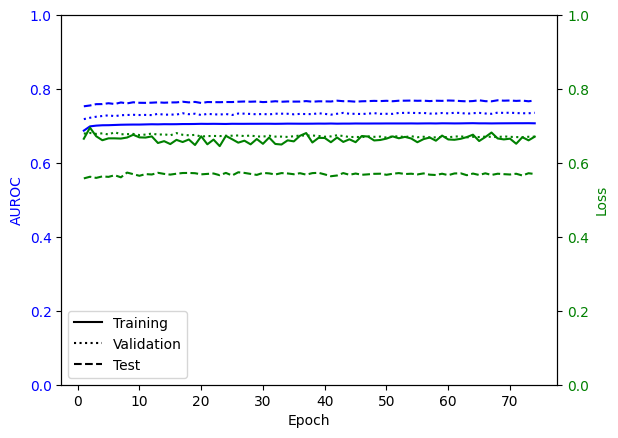

In [7]:
fig, ax1 = plt.subplots()

ax1.plot(train_aurocs.keys(), train_aurocs.values(), color='blue', label='Training')
ax1.plot(valid_aurocs.keys(), valid_aurocs.values(), color='blue', linestyle='dotted', label='Validation')
ax1.plot(test_aurocs.keys(), test_aurocs.values(), color='blue', linestyle='dashed', label='Test')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0, 1)

ax2 = ax1.twinx()
ax2.plot(train_losses.keys(), train_losses.values(), color='green', label='Training')
ax2.plot(valid_losses.keys(), valid_losses.values(), color='green', linestyle='dotted', label='Validation')
ax2.plot(test_losses.keys(), test_losses.values(), color='green', linestyle='dashed', label='Test')
ax2.tick_params(axis='y', labelcolor='green')
ax2.set_ylim(0, 1)

ax1.set_ylabel('AUROC', color='blue')
ax2.set_ylabel('Loss', color='Green')
ax1.set_xlabel('Epoch')
ax1.legend(loc='lower left')
leg = ax1.get_legend()
for i in range(3):
    leg.legend_handles[i].set_color('black')

## Examine test set predictions
We've saved the prediction tensors for both edges and edge labels from the STHN code. The STHN code does not turn these predictions into human-readable forms, so here, we will explore the possibility of doing this.

In [35]:
test_preds = torch.load('../../STHN/DATA/drought_desiccation/model_predictions/test_epoch_0_pred_tensors.pt', map_location=torch.device('cpu'))

In [36]:
len(test_preds)

223

In [34]:
torch.sigmoid(test_preds[0]).shape

torch.Size([828, 4])

## Use trained model to make predictions for 2024
The STHN code doesn't have a built-in way to make actual rpedictions, so I added a line of code to save the model. Here, we'll read it in and make predictions for 2024, so we can examine them.

First, we have to set up the configs required by the model class. I added a print statement to print out the values for both dictionaries so we can just paste them here:

In [8]:
edge_predictor_configs = {'dim_in_time': 100,
                          'dim_in_node': 0,
                          'predict_class': 4}

In [9]:
mixer_configs =  {'per_graph_size': 50,
                  'time_channels': 100,
                  'input_channels': 3,
                  'hidden_channels': 100,
                  'out_channels': 100,
                  'num_layers': 1,
                  'dropout': 0.1,
                  'channel_expansion_factor': 2,
                  'window_size': 5,
                  'use_single_layer': False}

If I try to load the state dict into an STHN model initialized with the above parameters, I get a size mismatch error. According to [this stackoverflow post](https://stackoverflow.com/questions/67838192/size-mismatch-runtime-error-when-trying-to-load-a-pytorch-model), this means my model was trained on a different number of classes than the one I just instantiated. Since I instantiated it with the same exact parameters here as were used during trainng, I find this odd. However, one of [the answers](https://stackoverflow.com/a/76154523/13340814) offers a way to bypass any weights that have shape mismatches. Let's try it and see how many we had to use:

In [10]:
loaded_state_dict = torch.load('../../STHN/DATA/drought_desiccation/trained_dt_model')
sthn_model = STHN_Interface(mixer_configs, edge_predictor_configs)
current_model_dict = sthn_model.state_dict()
new_state_dict = {k:v if v.size()==current_model_dict[k].size()  else  current_model_dict[k] for k,v in zip(current_model_dict.keys(), loaded_state_dict.values())}
sthn_model.load_state_dict(new_state_dict, strict=False)

<All keys matched successfully>

In [11]:
for k,v in zip(current_model_dict.keys(), loaded_state_dict.values()):
    if not v.size() == current_model_dict[k].size():
        print(f'Weight {k} was loaded from new model.')
print(f'There are {len(new_state_dict)} total parameters.')

There are 32 total parameters.


Only two of the 32 parameters had a size mismatch issue. For now I will use this loaded model, but I will come back to see if I can figure out what's going on there later on.

The line that computes predictions in the STHN code is:

```
loss, pred, edge_label = model(inputs, neg_samples, subgraph_node_feats)
```

Let's see if we can figure out what the format of all those elements should be, and see if we can make a prediction on the whole graph.

In [17]:
def load_graph(d):
    df = pd.read_csv('../../STHN/DATA/{}/edges.csv'.format(d))
    g = np.load('../../STHN/DATA/{}/ext_full.npz'.format(d))

    return g, df

In [18]:
def load_all_data(args):
    """
    Copied from train.py and modified to take a dict instead of an
    argparse instance.
    """

    # load graph
    g, df = load_graph(args['data'])

    args['train_edge_end'] = df[df['ext_roll'].gt(0)].index[0]
    args['val_edge_end'] = df[df['ext_roll'].gt(1)].index[0]
    args['num_nodes'] = max(int(df['src'].max()), int(df['dst'].max())) + 1
    args['num_edges'] = len(df)
    print('Train %d, Valid %d, Test %d' %
          (args['train_edge_end'], args['val_edge_end'] - args['train_edge_end'],
           len(df) - args['val_edge_end']))
    print('Num nodes %d, num edges %d' % (args['num_nodes'], args['num_edges']))

    # load feats
    node_feats, edge_feats = load_feat(args['data'])
    node_feat_dims = 0 if node_feats is None else node_feats.shape[1]
    edge_feat_dims = 0 if edge_feats is None else edge_feats.shape[1]

    # feature pre-processing
    ## This was all False for us
#     if args['use_onehot_node_feats']: 
#         print('>>> Use one-hot node features')
#         node_feats = torch.eye(args['num_nodes'])
#         node_feat_dims = node_feats.size(1)

#     if args.ignore_node_feats:
#         print('>>> Ignore node features')
#         node_feats = None
#         node_feat_dims = 0

#     if args.use_type_feats:
#         edge_type = df.label.values
#         args['num_edgeType'] = len(set(edge_type.tolist()))
#         edge_feats = torch.nn.functional.one_hot(torch.from_numpy(edge_type -
#                                                                   1),
#                                                  num_classes=args['num_edgeType'])
#         edge_feat_dims = edge_feats.size(1)

    print('Node feature dim %d, edge feature dim %d' %
          (node_feat_dims, edge_feat_dims))

    # double check (if data leakage then cannot continue the code)
#     if args.check_data_leakage:
#                 check_data_leakage(args, g, df)

    args['node_feat_dims'] = node_feat_dims
    args['edge_feat_dims'] = edge_feat_dims

    if node_feats != None:
        node_feats = node_feats.to(args['device'])
    if edge_feats != None:
        edge_feats = edge_feats.to(args['device'])

    return node_feats, edge_feats, g, df, args

In [19]:
args = {
    'data': 'drought_desiccation',
    'device': 0,
    'num_edgeType': 4,
    'num_neighbors': 50,
    'batch_size': 600,
    'sampled_num_hops': 1
}

In [20]:
node_feats, edge_feats, g, df, args = load_all_data(args)

Train 939296, Valid 216485, Test 133433
Num nodes 334579, num edges 1289214
Node feature dim 0, edge feature dim 0


In [21]:
def pre_compute_subgraphs(args, g, df, mode):
    ###################################################

    extra_neg_samples = 1

    ###################################################
    # for each node, sample its neighbors with the most recent neighbors (sorted) 
    print('Sample subgraphs ... for %s mode'%mode)
    sampler, neg_link_sampler = get_parallel_sampler(g, args['num_neighbors'])

    ###################################################
    # setup modes
    if mode == 'train':
        cur_df = df[:args['train_edge_end']]

    elif mode == 'valid':
        cur_df = df[args['train_edge_end']:args['val_edge_end']]

    elif mode == 'test':
        cur_df = df[args['val_edge_end']:]
        loader = cur_df.groupby(cur_df.index // args['batch_size'])
    pbar = tqdm(total=len(loader))
    pbar.set_description('Pre-sampling: %s mode with negative sampleds %s ...'%(mode, extra_neg_samples))

    ###################################################
    all_subgraphs = []
    all_elabel = []
    sampler.reset()
    for _, rows in loader:

        root_nodes = np.concatenate(
            [rows.src.values, 
             rows.dst.values, 
             neg_link_sampler.sample(len(rows) * extra_neg_samples)]
        ).astype(np.int32)

        # time-stamp for node = edge time-stamp
        ts = np.tile(rows.time.values, extra_neg_samples + 2).astype(np.float32)
        all_elabel.append(rows.label.values)
        all_subgraphs.append(get_mini_batch(sampler, root_nodes, ts, args['sampled_num_hops']))

        pbar.update(1)
    pbar.close()
    subgraph_elabel = (all_subgraphs, all_elabel)
    try:
        pickle.dump(subgraph_elabel, open(fn, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
    except:
        print('For some shit reason pickle cannot save ... but anyway ...')

        ###################################################
        
    return subgraph_elabel

In [22]:
test_subgraphs = pre_compute_subgraphs(args, g, df, mode='test')

Sample subgraphs ... for test mode


Pre-sampling: test mode with negative sampleds 1 ...: 100%|██████████| 223/223 [07:20<00:00,  1.97s/it]

For some shit reason pickle cannot save ... but anyway ...


In [23]:
subgraphs, elabel = test_subgraphs

In [24]:
cached_neg_samples = 1
neg_samples = 1

In [25]:
subgraph_data_list = subgraphs[0]
subgraph_data = subgraphs[0].mini_batch(
                0, get_random_inds(
                len(subgraph_data_list), cached_neg_samples, neg_samples))

AttributeError: 'list' object has no attribute 'mini_batch'

In [ ]:
num_of_df_links = len(subgraph_data_list) // (cached_neg_samples + 2)

In [ ]:
subgraph_node_feats = compute_sign_feats(
                node_feats, df, args['val_edge_end'], num_of_df_links,
                subgraph_data['root_nodes'], args)

In [ ]:
# This is how the run command is used for test set
run(copy.deepcopy(model),
   None,
   args,
   test_subgraphs,
   df,
   node_feats,
   edge_feats,
   test_AUROC,
   test_AUPRC,
   mode='test')